# Notebook to load pre-trained model and perform inference on some S2 satellite imagery data

* Load some example data from the bucket

* Perform some pre-processing (normalisation of bands)

* Load a user chosen model

* Perform inference on data using chosen model

* Calculate some metrics against the ground truth data

* Visualise the predictions

In [1]:
import sys
sys.path.append("..")

In [2]:
import torch
import numpy as np
from pipelines.models import model_setup, metrics

# from utils import plot_preds, fsutils, pred_by_tiles, process_results
# from utils import fsutils, pred_by_tiles, process_results

In [3]:
class AttrDict(dict):
    """ Dictionary subclass whose entries can be accessed like attributes
        (as well as normally).
    """

    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

    @staticmethod
    def from_nested_dicts(data):
        """ Construct nested AttrDicts from nested dictionaries. """
        if not isinstance(data, dict):
            return data
        else:
            return AttrDict({key: AttrDict.from_nested_dicts(data[key])
                             for key in data})

In [8]:
# Define some options

# Brown, Blue, White colormap for ground truth
COLORS_WORLDFLOODS = np.array([[139, 64, 0],
                               [0, 0, 139],
                               [220, 220, 220]], dtype=np.float32) / 255


# FREQUENCY_CLASSES = [0.120252 + 0.396639, 0.027322, .455787]

model_name = 'simplecnn'
channel_configuration_name = 'all'
opt = {
    'model': model_name,
    'device': 'cpu',
    'model_folder': f'../pipelines/models/checkpoints/{model_name}/', # TODO different channel configuration means different model
    'max_tile_size': 128,
    'num_class': 3,
    'channel_configuration' : channel_configuration_name,
    'num_channels': len(model_setup.CHANNELS_CONFIGURATIONS[channel_configuration_name]),
}
opt = AttrDict.from_nested_dicts(opt)

In [9]:
pred_fun_final = model_setup.model_inference_fun(opt)

Model  : simplecnn
Using latest model: ../pipelines/models/checkpoints/simplecnn/simplecnn_final_weights.pt


## Read Some data

In [10]:
import rasterio
import numpy as np
from rasterio import plot as rasterioplt
import matplotlib.pyplot as plt

In [11]:
# layer_name, window = "EMSR347_07ZOMBA_DEL_v2_observed_event_a", None

layer_name, window = "EMSR333_02PORTOPALO_DEL_MONIT01_v1_observed_event_a", (slice(1000,None),slice(0,400))

tiff_inputs = f"gs://worldfloods/tiffimages/S2/{layer_name}.tif"
tiff_targets = f"gs://worldfloods/tiffimages/gt/{layer_name}.tif"

with rasterio.open(tiff_inputs, "r") as rst:
    inputs = rst.read((np.array(model_setup.CHANNELS_CONFIGURATIONS['all']) + 1).tolist(), window=window)
    # Shifted transform based on the given window (used for plotting)
    transform = rst.transform if window is None else rasterio.windows.transform(window, rst.transform)
    
with rasterio.open(tiff_targets, "r") as rst:
    targets = rst.read(1, window=window)

(13, 391, 400)


<AxesSubplot:>

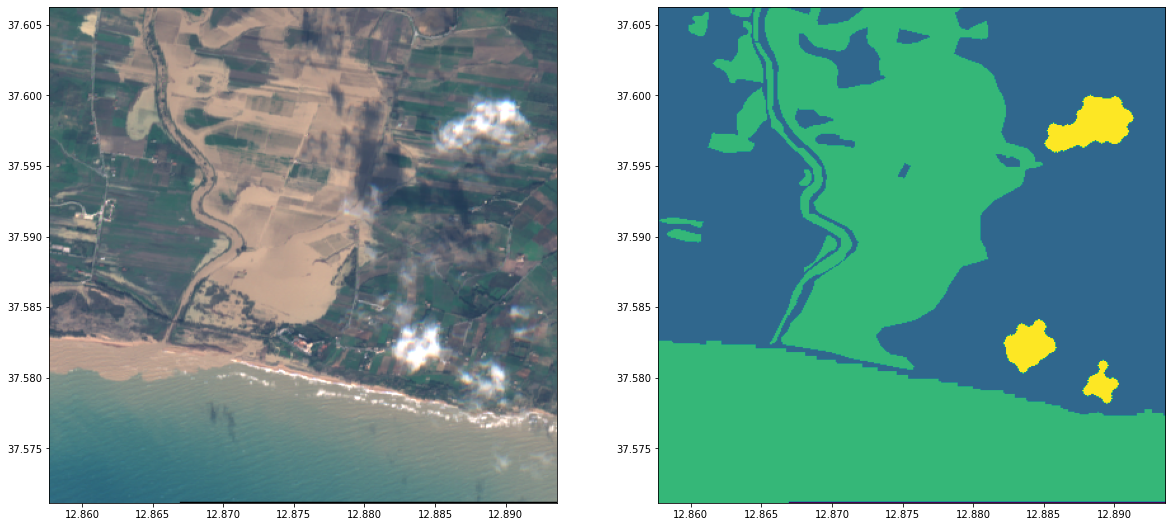

In [12]:
fig, ax = plt.subplots(1,2,figsize=(20,16))

rgb = np.clip(inputs[[3,2,1], :, :]/3000.,0,1)
print(inputs.shape)

rasterioplt.show(rgb,transform=transform,ax=ax[0])
rasterioplt.show(targets,transform=transform,ax=ax[1])

## Normalise the input image before sending to model

In [ ]:

torch_inputs = torch.from_numpy(inputs.astype(np.float32)).unsqueeze(0)
outputs = pred_fun_final(torch_inputs)

prediction = torch.argmax(outputs, dim=1).long()

In [ ]:
print(np.unique(targets))

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,16))

rgb = np.clip(inputs[[3,2,1], :, :]/3000.,0,1)
print(inputs.shape)

prediction_show = np.array(prediction) + 1

rasterioplt.show(rgb,transform=transform,ax=ax[0])
rasterioplt.show(targets,transform=transform,ax=ax[1], vmin=0, vmax=opt.num_class)
rasterioplt.show(prediction_show, transform=transform, ax=ax[2], vmin=0, vmax=opt.num_class)

In [ ]:
confusion_mat = metrics.compute_confusions(torch.Tensor(targets).unsqueeze(0), prediction, opt.num_class, remove_class_zero=True) # (batch_size, num_class, num_class)
confusion_mat = confusion_mat.sum(dim=0) # add by the batch dimension
confusion_mat.shape

In [ ]:
print(confusion_mat)

In [ ]:
metrics.cm_analysis(np.array(confusion_mat), labels=["land","water","cloud"])